## Preprocessing Data ##

Managing data Source: https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask

TIP 1 - Deleting unused variables and gc.collect()

TIP 2 - Presetting the datatypes

TIP 3 - Importing selected rows of the a file (including generating your own subsamples)

TIP 5 - Importing just selected columns

TIP 6 - Creative data processing

In [17]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn import metrics

** Load Data **

Loading data from csv unfortunately due to memory issues I was not able to utilize all 184 million data

In [2]:
# Import only selected cols and presetting data types
train_cols = [
            'ip', 
            'app', 
            'device', 
            'os', 
            'channel', 
            'click_time', 
            'is_attributed'
            ]

test_cols  = [
            'ip', 
            'app', 
            'device', 
            'os', 
            'channel', 
            'click_time', 
            'click_id'
            ]

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [3]:
start_time = time.time()

train = pd.read_csv("data/train.csv", skiprows=range(1,100000000), nrows=84903891, usecols=train_cols, dtype=dtypes)
test = pd.read_csv("data/test_supplement.csv", usecols=test_cols, dtype=dtypes)

print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 134.34629154205322


In [4]:
train.shape

(84903891, 7)

In [5]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,38311,11,1,15,219,2017-11-08 09:38:15,0
1,42430,9,1,25,334,2017-11-08 09:38:15,0
2,268617,12,1,19,219,2017-11-08 09:38:15,0
3,120245,18,1,25,107,2017-11-08 09:38:15,0
4,118252,3,1,9,280,2017-11-08 09:38:15,0


** Create new features **

In [6]:
# Method to create new features as well as drop columns that will no longer be use
def new_features(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['click_day'] = df['datetime'].dt.day
    df["click_hour"] = df["datetime"].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    # Drop columns no longer needed to manage data
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [7]:
start_time = time.time()

# labels
y = train['is_attributed']

train.drop(['is_attributed'], axis=1, inplace=True)
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()
print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 6.537474155426025


In [8]:
start_time = time.time()
# Count the number of clicks by ip
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']

merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 56.41985487937927


In [9]:
start_time = time.time()

train = new_features(train)
gc.collect()

print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 40.27451252937317


In [10]:
train.head()

,app,device,os,channel,clicks_by_ip,click_day,click_hour,day_of_week
0,11,1,15,219,3618,8,9,2
1,9,1,25,334,7284,8,9,2
2,12,1,19,219,39,8,9,2
3,18,1,25,107,1689,8,9,2
4,3,1,9,280,730,8,9,2


## Train Model ##

Source: 

https://www.datacamp.com/community/tutorials/xgboost-in-python

https://xgboost.readthedocs.io/en/latest/parameter.html

https://xgboost.readthedocs.io/en/latest/python/python_api.html

Parameters obtain from using GridSearchCV. Can be found in optimized_parameters.ipybn

xgb.train() was used for incremental training instead of xgb.XGBClassifier()

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,

       colsample_bytree=0.59999999999999998, gamma=0.01,
       
       learning_rate=0.20000000000000001, max_delta_step=15, max_depth=5,
       
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=4,
       
       nthread=None, objective='gpu:binary:logistic', random_state=45,
       
       reg_alpha=0, reg_lambda=1000, scale_pos_weight=99, seed=None,
       
       silent=True, subsample=1, tree_method='gpu_hist')
       
********************************************************************
Best ROC-AUC Score:

0.993763375903

In [11]:
# Parameters used for XGBoost
params = {
        'tree_method': 'gpu_hist', # Equivalent to the XGBoost fast histogram algorithm. Much faster and uses considerably less memory. NOTE: Will run very slowly on GPUs older than Pascal architecture.
        'colsample_bytree': 0.6, #  Subsample ratio of columns when constructing each tree
        'gamma': 0.01, # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'learning_rate': .2, # Boosting learning rate
        'max_delta_step': 15, # Maximum delta step we allow each tree’s weight estimation to be.
        'max_depth': 5, # Maximum depth of a tree.
        'min_child_weight': 5, # Minimum sum of instance weight(hessian) needed in a child.
        'n_jobs': 4, #  Number of parallel threads used to run xgboost. (replaces nthread)
        'objective': 'gpu:binary:logistic', # logistic regression for binary classification, output probability base on gpu
        'reg_lambda': 1000, # L2 regularization term on weights
        'scale_pos_weight': 99, # Balancing of positive and negative weights. Since we have imbalance ratio of 99:1
        'random_state': 45, # Random number seed
        'eval_metric': 'auc', # Scoring Grade
        'silent': True, # silent [default=0] 0 means printing running messages, 1 means silent mode
        'predictor':'cpu_predictor' # The type of predictor algorithm to use. Provides the same results but allows the use of GPU or CPU.
}

In [12]:
start_time = time.time()
print('Start Training')
  
#data_dmatrix = xgb.DMatrix(data=X,label=y)
dmatrixtrain = xgb.DMatrix(train, y)
del train, y
gc.collect()
#evals: List of items to be evaluated during training, this allows user to watch performance on the validation set.
evals = [(dmatrixtrain, 'train')]
#xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
model = xgb.train(params, dmatrixtrain, 100, evals, verbose_eval=1)

del dmatrixtrain
gc.collect()

print('Finish Training: {}'.format(time.time() - start_time))

Start Training
[0]	train-auc:0.796605
[1]	train-auc:0.887569
[2]	train-auc:0.901487
[3]	train-auc:0.902239
[4]	train-auc:0.947516
[5]	train-auc:0.94708
[6]	train-auc:0.954061
[7]	train-auc:0.953862
[8]	train-auc:0.953397
[9]	train-auc:0.951634
[10]	train-auc:0.953063
[11]	train-auc:0.957231
[12]	train-auc:0.957144
[13]	train-auc:0.959111
[14]	train-auc:0.960128
[15]	train-auc:0.95992
[16]	train-auc:0.960857
[17]	train-auc:0.962037
[18]	train-auc:0.962691
[19]	train-auc:0.963692
[20]	train-auc:0.964633
[21]	train-auc:0.964978
[22]	train-auc:0.965359
[23]	train-auc:0.965551
[24]	train-auc:0.965818
[25]	train-auc:0.966156
[26]	train-auc:0.966393
[27]	train-auc:0.96659
[28]	train-auc:0.967104
[29]	train-auc:0.967497
[30]	train-auc:0.967697
[31]	train-auc:0.967943
[32]	train-auc:0.968049
[33]	train-auc:0.968156
[34]	train-auc:0.968307
[35]	train-auc:0.968469
[36]	train-auc:0.96865
[37]	train-auc:0.968768
[38]	train-auc:0.968907
[39]	train-auc:0.96898
[40]	train-auc:0.96915
[41]	train-auc:0.

## Feature Importance ##

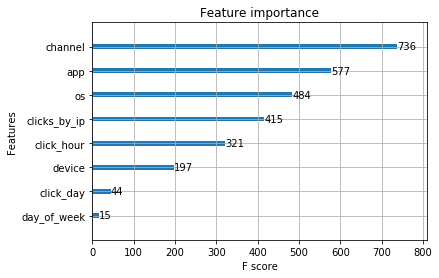

In [13]:
# Plot the feature importance from xgboost
plot_importance(model)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

## Test Prediction ##

predict() will perform dropouts, i.e. only some of the trees will be evaluated. This will produce incorrect results if data is not the training data. To obtain correct results on test sets, set ntree_limit to a nonzero value, e.g.

In [14]:
start_time = time.time()

sub = pd.DataFrame()
# Load the test for predict 
test = pd.read_csv("data/test.csv", usecols=test_cols, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

sub['click_id'] = test['click_id'].astype('int')

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = new_features(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dmatrixtest = xgb.DMatrix(test)
del test
gc.collect()
print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 30.96998357772827


In [15]:
start_time = time.time()
# Save the predictions
sub['is_attributed'] = model.predict(dmatrixtest)
# Upload to Kaggle to get Score per submission
sub.to_csv('data/xgb_submission.csv', index=False)
print('Elapse Time: {}'.format(time.time() - start_time))

Elapse Time: 67.61624574661255


## RESULT ROC_AUC SCORE ##

Score was obtain from submitting xgb_submission.csv to kaggle per submission guidelines - https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

<img src="results.png">